## Notebook to experiment with porting Hooke model and latent spaces over to python
Eventual hope is to write code that can infer latent position and pseudostage for hotfish and other perturbed embryos

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import os
import glob2 as glob
import patsy

# set paths
fig_root = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/figures/seq_data/PLN/"


# specify which regression to use
ccm = "t_spline_inter2" #"t_spline_inter"

fig_folder = os.path.join(fig_root, ccm, "")
os.makedirs(fig_folder, exist_ok=True)

# set path to data
hooke_data_path = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/seq_data/emb_projections/hooke_model_files/"
ccs_data_path = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/seq_data/emb_projections/ccs_data_cell_type_broad/"
# hooke_data_path = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/seq_data/emb_projections/hooke_model_test/"
# ccs_data_path = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/seq_data/emb_projections/ccs_data_test/"
model_path = os.path.join(hooke_data_path, ccm, "")

### Load in metadata, model params, and counts matrice 

In [2]:
# load full counts dataset
hooke_counts_long = pd.read_csv(model_path + "abundance_estimates.csv", index_col=0)
cols = list(hooke_counts_long.columns)
cell_ind = cols.index("cell_group")
cov_cols = cols[:cell_ind]
hooke_counts_df = hooke_counts_long.pivot(index=cov_cols,
                                           columns=["cell_group"], values = ["log_abund"])
hooke_counts_df.columns = ['_'.join(map(str, col)).strip('_') for col in hooke_counts_df.columns.values]
hooke_counts_df.reset_index(inplace=True)
new_cols = [col.replace("log_abund_", "") for col in hooke_counts_df.columns.values]
hooke_counts_df.columns = new_cols
sort_cols = new_cols[:cell_ind] + sorted(new_cols[cell_ind:], key=str.lower)
hooke_counts_df = hooke_counts_df.loc[:, sort_cols]
# meta_df = pd.read_csv(ccs_data_path + "mdl_embryo_metadata.csv", index_col=0)
# meta_df["dis_protocol_str"] = meta_df["dis_protocol"].astype(str)

# model formula
with open(model_path + "model_string.txt", "r") as file:
    formula_str = file.read()
formula_str = "dummy_response " + formula_str 
formula_str = formula_str.replace("ns(", "cr(")
formula_str = formula_str.replace("c(", "(")
formula_str = formula_str.replace("\n", "")

# load hooke predictions (for comparison purposes)
latent_df = pd.read_csv(model_path + "latents.csv", index_col=0)
time_splines = pd.read_csv(model_path + "time_splines.csv")

# load hooke model files
# b_array = pd.read_csv(model_path + "B.csv", index_col=0)
cov_array = pd.read_csv(model_path + "COV.csv", index_col=0)
theta_array = pd.read_csv(model_path + "Theta.csv", index_col=0)

# latent_df.head()
theta_array = theta_array.rename(columns={"(Intercept)":"Intercept"})
cols_from = theta_array.columns
cols_from_clean = [col.replace(" = c", "=") for col in cols_from]
theta_array.columns = cols_from_clean

time_splines.head()

timepoint    t_spline_1  t_spline_2  t_spline_3  t_spline_4
0   3.000000  0.000000e+00    0.000000    0.000000    0.000000
1   3.093093  1.069873e-08   -0.001015    0.003046   -0.002030
2   3.186186  8.558985e-08   -0.002030    0.006091   -0.004061
3   3.279279  2.888657e-07   -0.003045    0.009136   -0.006091
4   3.372372  6.847188e-07   -0.004060    0.012181   -0.008121

In [3]:
from scipy.interpolate import interp1d
# Assume the lookup table has columns: "timepoint", "V1", "V2", "V3", "V4"
# (The actual names might differ; adjust as necessary.)

# Define a function to interpolate the spline basis for a new time value.
def get_spline_basis(new_time_vec, lookup_df):
    # Create an empty dictionary to hold the interpolated values.
    out_df = pd.DataFrame(new_time_vec, columns=["timepoint"])
    
    # Loop through each spline column (skip the "timepoint" column).
    for col in lookup_df.columns[1:]:
        # Create an interpolation function for this column.
        f_interp = interp1d(lookup_df["timepoint"], lookup_df[col],
                            kind='linear', fill_value="extrapolate")
        # Evaluate the interpolation at the new time value.
        out_df[col] = f_interp(new_time_vec)
    return out_df

### Experiment with building covariate matrix with patsy

In [46]:
def get_covariate_df(formula_str, meta_df, time_splines):
    meta_df["dummy_response"] = 0
    _, X = patsy.dmatrices(formula_str, meta_df, return_type='dataframe')
    col_list = list(X.columns)
    cols_to_clean = [col.replace("[T.", "") for col in col_list]
    cols_to_clean = [col.replace("]", "") for col in cols_to_clean]
    cols_to_clean = [col.replace("[", "") for col in cols_to_clean]
    cols_to_clean = [col.replace("cr", "ns") for col in cols_to_clean]
    cols_to_keep = [col for col in cols_to_clean if col in cols_from_clean]
    X.columns = cols_to_clean
    X = X.loc[:, cols_to_keep]
    
    # replace spline cols with lookups (can't get patsy to match ns from R)
    spline_cols = [col for col in cols_to_keep if "ns(" in col]
    spline_vals = get_spline_basis(meta_df.loc[:, "timepoint"].to_numpy(), time_splines)
    if "inter" in ccm:
        X.loc[:, spline_cols[:4]] = spline_vals.iloc[:, 1:].to_numpy()
        X.loc[:, spline_cols[4:]] = np.multiply(spline_vals.iloc[:, 1:].to_numpy(), X.loc[:, "dis_protocol"].to_numpy()[:, None])
    else:
        X.loc[:, spline_cols] = spline_vals.iloc[:, 1:].to_numpy()

    return X, spline_vals.iloc[:, 0].to_numpy()

In [24]:
meta_df = hooke_counts_df[cov_cols].copy()
meta_df.loc[:, "dummy_response"] = 0

X = get_covariate_df(formula_str, meta_df, time_splines)

X.head()

Intercept  exptCHEM2  exptCHEM3  exptCHEM5  exptGAP13  exptGAP14  \
0        1.0        0.0        0.0        0.0        0.0        0.0   
1        1.0        1.0        0.0        0.0        0.0        0.0   
2        1.0        0.0        1.0        0.0        0.0        0.0   
3        1.0        0.0        0.0        1.0        0.0        0.0   
4        1.0        0.0        0.0        0.0        1.0        0.0   

   exptGAP16  exptGAP18  exptHF4  exptREF1  ...  expthotfish2  \
0        0.0        0.0      0.0       0.0  ...           0.0   
1        0.0        0.0      0.0       0.0  ...           0.0   
2        0.0        0.0      0.0       0.0  ...           0.0   
3        0.0        0.0      0.0       0.0  ...           0.0   
4        0.0        0.0      0.0       0.0  ...           0.0   

   ns(timepoint, knots=(26.25, 49.5, 72.75))1  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   

   ns(timepoint, knots=(26.25, 49.5, 72.75))2  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   

   ns(timepoint, knots=(26.25, 49.5, 72.75))3  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   

   ns(timepoint, knots=(26.25, 49.5, 72.75))4  dis_protocol  \
0                                         0.0           1.0   
1                                         0.0           1.0   
2                                         0.0           1.0   
3                                         0.0           1.0   
4                                         0.0           1.0   

   ns(timepoint, knots=(26.25, 49.5, 72.75))1:dis_protocol  \
0                                                0.0         
1                                                0.0         
2                                                0.0         
3                                                0.0         
4                                                0.0         

   ns(timepoint, knots=(26.25, 49.5, 72.75))2:dis_protocol  \
0                                                0.0         
1                                                0.0         
2                                                0.0         
3                                                0.0         
4                                                0.0         

   ns(timepoint, knots=(26.25, 49.5, 72.75))3:dis_protocol  \
0                                                0.0         
1                                                0.0         
2                                                0.0         
3                                                0.0         
4                                                0.0         

   ns(timepoint, knots=(26.25, 49.5, 72.75))4:dis_protocol  
0                                                0.0        
1                                                0.0        
2                                                0.0        
3                                                0.0        
4                                                0.0        

[5 rows x 21 columns]

### Verify that our predictions are consistent with output of Hooke's "estimate_abundances" function

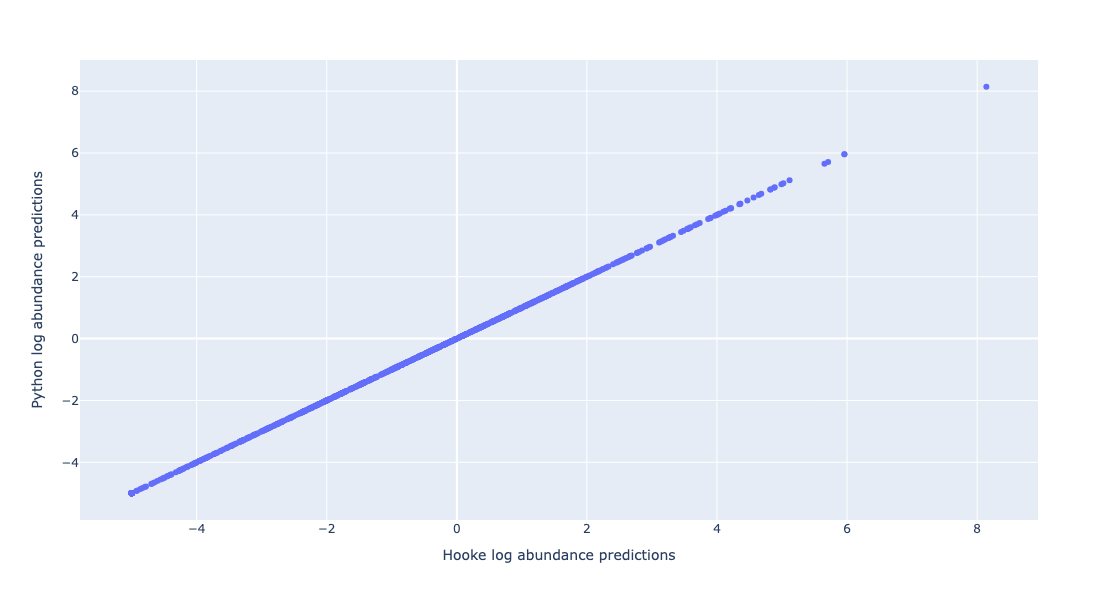

In [25]:
mu_python = np.matmul(X, theta_array.T)
mu_python[mu_python < -5] = -5 # looks like Hooke applies a lower bound at log(counts)=-5
python_pd = mu_python.to_numpy().ravel()
hooke_pd = hooke_counts_df.iloc[:, cell_ind:].to_numpy().ravel()

plot_indices = np.random.choice(range(len(hooke_pd)), 1000)
fig = px.scatter(x=hooke_pd[plot_indices], y=python_pd[plot_indices])

fig.update_layout(
    xaxis_title="Hooke log abundance predictions",
    yaxis_title="Python log abundance predictions"
)

fig.update_layout(width=800, height=600) 
fig.show()

fig.write_image(fig_folder + "python_pd_validation.png", scale=2)
fig.write_html(fig_folder + "python_pd_validation.html")

### Generate mean WT trajectories
Let's generate a high-res time trajectory. Look at differences between bead and enzymatic protocols. Average across experiment offsets (does that make sense?)

In [71]:
import itertools

nt = 100
dis_protocol_vals = np.unique(meta_df["dis_protocol"]).tolist()
expt_vals = np.unique(meta_df["expt"]).tolist()
time_vals = np.linspace(12, 74, nt).tolist()

query_df = pd.DataFrame(itertools.product(time_vals, dis_protocol_vals, expt_vals), columns=["timepoint", "dis_protocol", "expt"])

# get covariate matrix
X_ref, t_vec = get_covariate_df(formula_str, query_df, time_splines)
expt_cols = [col for col in X_ref.columns if "expt" in col]
# null_expt_filter = np.all(X_ref.loc[:, expt_cols].to_numpy()==0, axis=1)
null_expt_filter = X_ref.loc[:, "dis_protocol"]==2
X_ref = X_ref.loc[null_expt_filter, :]
exp_vec = np.argmax(X_ref.loc[:, expt_cols], axis=1)
t_vec = t_vec[null_expt_filter]
# get log abundance predictions

abundance_pd = np.matmul(X_ref, theta_array.T)
X_ref.head()

Intercept  exptCHEM2  exptCHEM3  exptCHEM5  exptGAP13  exptGAP14  \
12        1.0        0.0        0.0        0.0        0.0        0.0   
13        1.0        1.0        0.0        0.0        0.0        0.0   
14        1.0        0.0        1.0        0.0        0.0        0.0   
15        1.0        0.0        0.0        1.0        0.0        0.0   
16        1.0        0.0        0.0        0.0        1.0        0.0   

    exptGAP16  exptGAP18  exptHF4  exptREF1  ...  expthotfish2  \
12        0.0        0.0      0.0       0.0  ...           0.0   
13        0.0        0.0      0.0       0.0  ...           0.0   
14        0.0        0.0      0.0       0.0  ...           0.0   
15        0.0        0.0      0.0       0.0  ...           0.0   
16        0.0        0.0      0.0       0.0  ...           0.0   

    ns(timepoint, knots=(26.25, 49.5, 72.75))1  \
12                                    0.009668   
13                                    0.009668   
14                                    0.009668   
15                                    0.009668   
16                                    0.009668   

    ns(timepoint, knots=(26.25, 49.5, 72.75))2  \
12                                   -0.093244   
13                                   -0.093244   
14                                   -0.093244   
15                                   -0.093244   
16                                   -0.093244   

    ns(timepoint, knots=(26.25, 49.5, 72.75))3  \
12                                    0.279733   
13                                    0.279733   
14                                    0.279733   
15                                    0.279733   
16                                    0.279733   

    ns(timepoint, knots=(26.25, 49.5, 72.75))4  dis_protocol  \
12                                   -0.186489           2.0   
13                                   -0.186489           2.0   
14                                   -0.186489           2.0   
15                                   -0.186489           2.0   
16                                   -0.186489           2.0   

    ns(timepoint, knots=(26.25, 49.5, 72.75))1:dis_protocol  \
12                                           0.019336         
13                                           0.019336         
14                                           0.019336         
15                                           0.019336         
16                                           0.019336         

    ns(timepoint, knots=(26.25, 49.5, 72.75))2:dis_protocol  \
12                                          -0.186489         
13                                          -0.186489         
14                                          -0.186489         
15                                          -0.186489         
16                                          -0.186489         

    ns(timepoint, knots=(26.25, 49.5, 72.75))3:dis_protocol  \
12                                           0.559466         
13                                           0.559466         
14                                           0.559466         
15                                           0.559466         
16                                           0.559466         

    ns(timepoint, knots=(26.25, 49.5, 72.75))4:dis_protocol  
12                                          -0.372977        
13                                          -0.372977        
14                                          -0.372977        
15                                          -0.372977        
16                                          -0.372977        

[5 rows x 21 columns]

In [77]:
X_ref.loc[:, expt_cols].head()

exptCHEM2  exptCHEM3  exptCHEM5  exptGAP13  exptGAP14  exptGAP16  \
12        0.0        0.0        0.0        0.0        0.0        0.0   
13        1.0        0.0        0.0        0.0        0.0        0.0   
14        0.0        1.0        0.0        0.0        0.0        0.0   
15        0.0        0.0        1.0        0.0        0.0        0.0   
16        0.0        0.0        0.0        1.0        0.0        0.0   

    exptGAP18  exptHF4  exptREF1  exptREF2  expthotfish2  
12        0.0      0.0       0.0       0.0           0.0  
13        0.0      0.0       0.0       0.0           0.0  
14        0.0      0.0       0.0       0.0           0.0  
15        0.0      0.0       0.0       0.0           0.0  
16        0.0      0.0       0.0       0.0           0.0

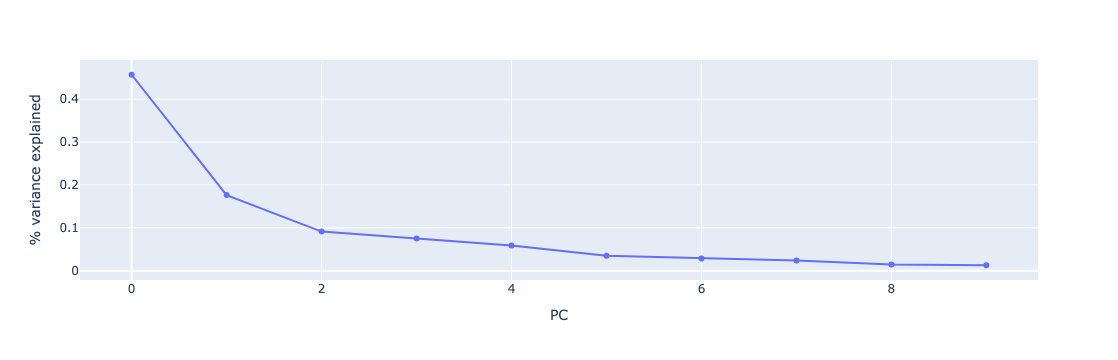

In [72]:
from sklearn.decomposition import PCA

n_pc = 10
pca = PCA(n_components=n_pc)
pca.fit(abundance_pd)

fig = px.line(x=np.arange(n_pc), y=pca.explained_variance_ratio_, markers=True)
fig.update_layout(
    xaxis_title="PC",
    yaxis_title="% variance explained"
)

fig.show()

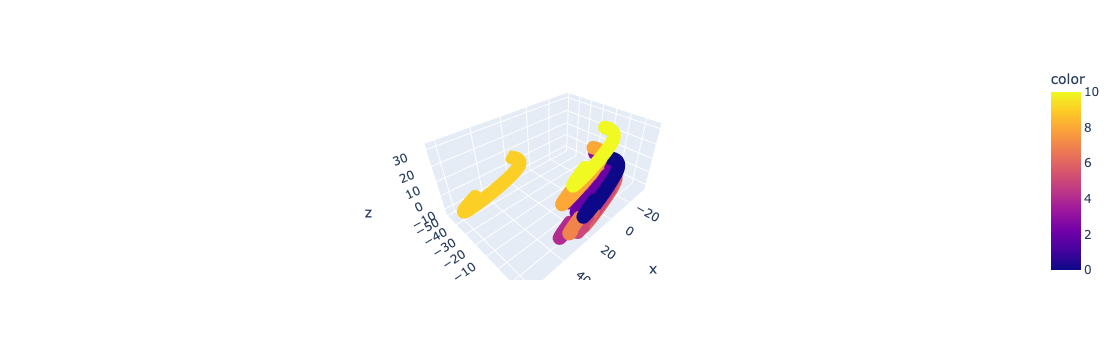

In [75]:
abundance_pca = pca.transform(abundance_pd)
fig = px.scatter_3d(x=abundance_pca[:, 0], y=abundance_pca[:, 1], z=abundance_pca[:, 2], color=exp_vec, 
                    hover_data={"dis":X_ref["dis_protocol"].to_numpy()})
fig.show()

/var/folders/m7/tpjttxb92tl8b4c9svgvgby00000gn/T/ipykernel_31301/2245713325.py:1: RuntimeWarning:

divide by zero encountered in log



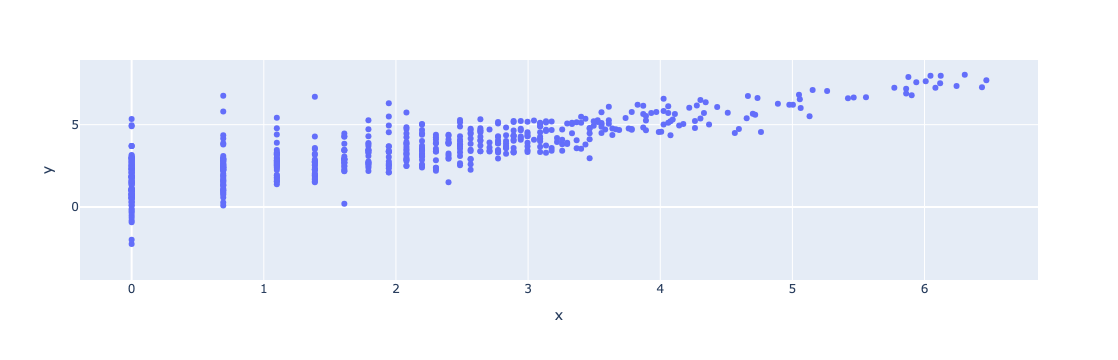

In [49]:
px.scatter(x=np.log(ccs_df.to_numpy()[:5, :].ravel()), 
           y=np.log(pd_python.loc[:, ccs_df.columns].to_numpy()[:5, :].ravel()))

In [66]:
ccs_df.T.head()

adenohypophysis  adrenal gland  annular ligament (doublets?)  \
CHEM1_P2_A10                1              0                             5   
CHEM1_P2_A12                5              0                             6   
CHEM1_P2_A2                 0              0                             0   
CHEM1_P2_A4                 1              1                             0   
CHEM1_P2_A6                 2              0                             0   

              anterior eye  apical ectodermal ridge  basal cell  \
CHEM1_P2_A10             4                       34         102   
CHEM1_P2_A12            12                       49         179   
CHEM1_P2_A2              4                       16          33   
CHEM1_P2_A4              3                        1          11   
CHEM1_P2_A6              6                       32          82   

              cardiomyocyte  chondrocranium  \
CHEM1_P2_A10              1               2   
CHEM1_P2_A12              0               7   
CHEM1_P2_A2               3               0   
CHEM1_P2_A4               2               0   
CHEM1_P2_A6               5               1   

              connective tissue-meninges-dermal FB, early  \
CHEM1_P2_A10                                            0   
CHEM1_P2_A12                                            0   
CHEM1_P2_A2                                             7   
CHEM1_P2_A4                                            19   
CHEM1_P2_A6                                             0   

              connective tissue-meninges-dermal FB, late  ...  \
CHEM1_P2_A10                                          46  ...   
CHEM1_P2_A12                                          77  ...   
CHEM1_P2_A2                                           47  ...   
CHEM1_P2_A4                                            2  ...   
CHEM1_P2_A6                                           98  ...   

              unknown (myeloid, tox2+, gse1+)  \
CHEM1_P2_A10                                6   
CHEM1_P2_A12                                2   
CHEM1_P2_A2                                 1   
CHEM1_P2_A4                                 0   
CHEM1_P2_A6                                 1   

              unknown (neural crest, jhy+, prickle1b+, prdm1a+)  \
CHEM1_P2_A10                                                  0   
CHEM1_P2_A12                                                  0   
CHEM1_P2_A2                                                   0   
CHEM1_P2_A4                                                   0   
CHEM1_P2_A6                                                   0   

              unknown (retina, pvalb7+)  unknown (stroma or muscle)  \
CHEM1_P2_A10                          1                           1   
CHEM1_P2_A12                          3                          10   
CHEM1_P2_A2                           0                           0   
CHEM1_P2_A4                           0                           0   
CHEM1_P2_A6                           0                           1   

              unknown (tenocyte, tnmd+, cdon+)  \
CHEM1_P2_A10                                 1   
CHEM1_P2_A12                                 2   
CHEM1_P2_A2                                  0   
CHEM1_P2_A4                                  0   
CHEM1_P2_A6                                  0   

              unknown 1 (pancreas, ins+, gcga+, gcgb+, isl1+, sst1.1+)  \
CHEM1_P2_A10                                                  0          
CHEM1_P2_A12                                                  0          
CHEM1_P2_A2                                                   0          
CHEM1_P2_A4                                                   0          
CHEM1_P2_A6                                                   0          

              unknown pronephros (possibly doublets)  vacuolated, notochord  \
CHEM1_P2_A10                                       0                      1   
CHEM1_P2_A12                                       0                    

In [67]:
ccs_pd_df.head()

adenohypophysis  adrenal gland  annular ligament (doublets?)  \
CHEM1_P2_A10         6.721565       4.367271                      5.358838   
CHEM1_P2_A12         6.898828       4.558570                      5.523821   
CHEM1_P2_A2          5.224809       3.729333                      3.244350   
CHEM1_P2_A4          4.344358       3.741847                      1.726475   
CHEM1_P2_A6          6.334581       4.254595                      4.772157   

              anterior eye  apical ectodermal ridge  basal cell  \
CHEM1_P2_A10      8.534594                 9.992265   10.585665   
CHEM1_P2_A12      8.884790                10.123633   10.550190   
CHEM1_P2_A2       7.054604                 7.788387    8.074566   
CHEM1_P2_A4       5.806809                 6.249226    6.576594   
CHEM1_P2_A6       8.342114                 9.341807    9.659804   

              cardiomyocyte  chondrocranium  \
CHEM1_P2_A10       7.575513        8.156515   
CHEM1_P2_A12       7.933927        7.916741   
CHEM1_P2_A2        6.703174        5.122094   
CHEM1_P2_A4        6.091006        3.516225   
CHEM1_P2_A6        7.575242        6.849061   

              connective tissue-meninges-dermal FB, early  \
CHEM1_P2_A10                                     5.070950   
CHEM1_P2_A12                                     6.113176   
CHEM1_P2_A2                                      6.763933   
CHEM1_P2_A4                                      7.388611   
CHEM1_P2_A6                                      6.593238   

              connective tissue-meninges-dermal FB, late  ...  \
CHEM1_P2_A10                                   10.105895  ...   
CHEM1_P2_A12                                   10.689340  ...   
CHEM1_P2_A2                                     8.726341  ...   
CHEM1_P2_A4                                     7.066828  ...   
CHEM1_P2_A6                                    10.199222  ...   

              unknown (myeloid, tox2+, gse1+)  \
CHEM1_P2_A10                         6.320213   
CHEM1_P2_A12                         6.025536   
CHEM1_P2_A2                          4.131603   
CHEM1_P2_A4                          3.558329   
CHEM1_P2_A6                          5.207624   

              unknown (neural crest, jhy+, prickle1b+, prdm1a+)  \
CHEM1_P2_A10                                           4.269614   
CHEM1_P2_A12                                           4.967224   
CHEM1_P2_A2                                            5.490821   
CHEM1_P2_A4                                            6.375772   
CHEM1_P2_A6                                            5.272134   

              unknown (retina, pvalb7+)  unknown (stroma or muscle)  \
CHEM1_P2_A10                   6.094853                    8.701187   
CHEM1_P2_A12                   5.226983                    9.029936   
CHEM1_P2_A2                    2.295321                    6.966574   
CHEM1_P2_A4                    1.265789                    5.492554   
CHEM1_P2_A6                    3.868638                    8.408444   

              unknown (tenocyte, tnmd+, cdon+)  \
CHEM1_P2_A10                          7.078771   
CHEM1_P2_A12                          7.093592   
CHEM1_P2_A2                           4.615651   
CHEM1_P2_A4                           3.057228   
CHEM1_P2_A6                           6.222474   

              unknown 1 (pancreas, ins+, gcga+, gcgb+, isl1+, sst1.1+)  \
CHEM1_P2_A10                                           3.138804          
CHEM1_P2_A12                                           3.241011          
CHEM1_P2_A2                                            2.768716          
CHEM1_P2_A4                                            3.268028          
CHEM1_P2_A6                                            3.009284          

              unknown pronephros (possibly doublets)  vacuolated, notochord  \
CHEM1_P2_A10                                5.590782               6.995284   
CHEM1_P2_A12                                5.790831               7.283